**Master MISS - TP2 - unsupervised (20/11/2020)**

**Contents**: Nicolas Duchateau

***

Variability analysis of cardiac shape data
===

## Objectives

* Continue using Python and the **scikit-learn** tools for machine learning,
* Conduct **unsupervised dimensionality reduction** of medical imaging data, and compare it with supervised dimensionality reduction.

## Overview

This lab continues the analysis of cardiac shapes done in TP1. The starting point is still the dataset in **notebookData.mat**.

<img src="HCM.gif" style="height: 400px;"/>

<br>
We will only use the following data:

<br>
* `shapeED`: the **myocardial centerline at end-diastole**, whose dimensions (101 x 2 x 67) stand for the number of subjects, the x-y coordinates, and the number of points along each curve. We will consider it as a <u>
high-dimensional object of (2 x 67) dimensions, for each of the samples,</u>

<br>
* `labels`: the **subgroup** to which each subject belongs (either healthy volunteer or patient with hypertrophic cardiomyopathy),

<br>
* We will only focus on the **71 subjects for which labels are known** (as we want to compare an unsupervised method with a supervised one),

<br>

**This exercise aims at analyzing the variability in the cardiac shapes at end-diastole,** by running unsupervised (PCA) and supervised (PLS regression) dimensionality reduction on the shapes data.

>**Note**: Before you begin, you should make sure that the data from **notebookData.mat** are correctly loaded.

In [6]:
import scipy.io as sio
import numpy as np
import math

fileName = "./notebookData.mat"

mat_contents = sio.loadmat(fileName)
mat_contents.keys()
if len(mat_contents.keys()) != 9:
    raise Exception('Error in loading data')
else:
    print('Data correctly loaded !')
    
labels = mat_contents['labels']-1
labels = np.where(np.isnan(labels),2,labels)
shapeED = mat_contents['shapeED']

idx = np.argwhere( labels < 2 )[:,0] ### subjects for which the label is known

shapeED = shapeED[idx,:,:] ### shape at end-diastole
labels = labels[idx].ravel()

Data correctly loaded !


## Part 1: Unsupervised dimensionality reduction with PCA

### Q1.1 
Let's first plot the **whole set of shapes at end-diastole** (beginning of the cycle).

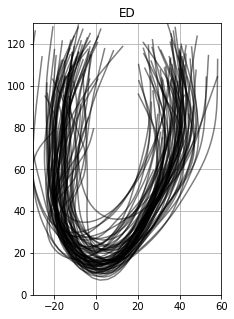

In [8]:
import matplotlib.pyplot as plt

numCases,_,numCP = shapeED.shape

fig,sub = plt.subplots(1,1,figsize=(5,5))

plt.subplots_adjust(wspace=0.25, hspace=0.1)

ax = sub
tmp = np.transpose( shapeED , axes=(2,0,1) )

ax.plot(tmp[:,:,0],tmp[:,:,1],color='k',alpha=0.5)
ax.set_aspect('equal')
ax.set_xlim(-30,60)
ax.set_ylim(0,130)
ax.grid()
ax.set_title(phase)
plt.show()

### Q1.2

Implement the **basic formula for PCA**:

In [9]:
X = shapeED
numDims = 2*numCP

### TODO: reshaping X to (numCases x numDims)
Xr = ### YOUR CODE HERE ###

### TODO: covariance matrix (beware of dimensions !)
COV = ### YOUR CODE HERE ###

### TODO: diagonalizing the covariance matrix and getting the eigenvalues and eigenvectors
values, vectors = ### YOUR CODE HERE ###

### reordering them from the largest to the smallest variations
values = values[::-1]
vectors = vectors[:,::-1]

Check the dimensions of `Xr`, `COV`, `values` and `vectors`. What do you think?

### Q1.3

Plot the amount of **explained variability**:

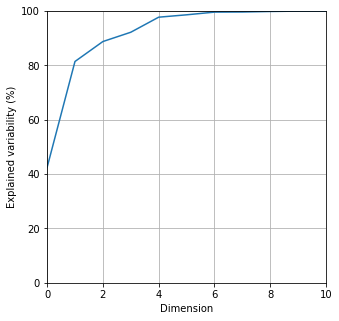

In [15]:
numDimsToPlot = 10

### TODO: compute the explained variability as the relative difference between a given eigenvalue and the sum of eigenvalues (in %)
explainedVariability = ### YOUR CODE HERE ###

fig,sub = plt.subplots(1,1,figsize=(5,5))
ax = sub
ax.plot( explainedVariability )
ax.set_xlim(0,numDimsToPlot)
ax.set_ylim(0,100)
ax.grid()
plt.xlabel('Dimension')
plt.ylabel('Explained variability (%)')
plt.show()


### Q1.4

**Reconstruct samples along the first dimensions** and visualize them:

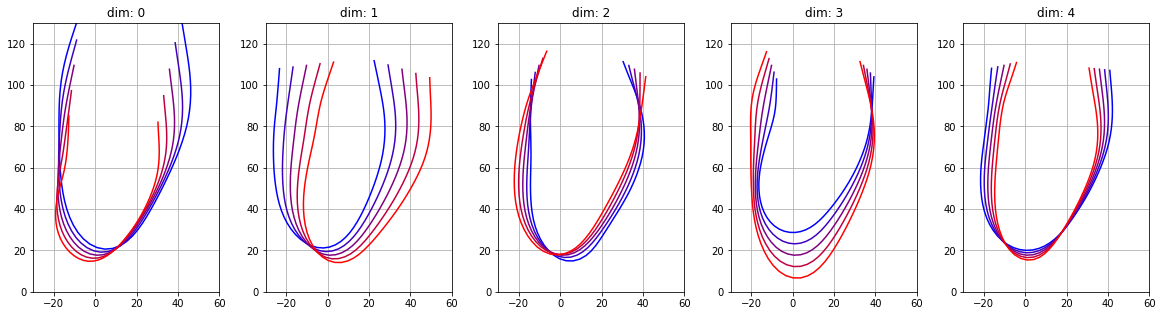

In [16]:
numDimsToPlot = 5
sigmaList = [-2,-1,0,1,2] ### Coefficients to move along the main modes of variation

fig,sub = plt.subplots(1,numDimsToPlot,figsize=(20,10))

### TODO: average of samples
mu = ### YOUR CODE HERE ###

plt.subplots_adjust(wspace=0.25, hspace=0.1)
for d in range(0,numDimsToPlot):
    for si, s in enumerate(sigmaList):
        ax = sub[d]

        yi = np.zeros(numDims)        
        yi[d] = s * math.sqrt(values[d])

        ### TODO: reconstruct samples as: P x yi + average
        ### beware of dimensions / transpositions !
        ### you can use "@" or "np.matmul" for matrix multiplication
        xi = ### YOUR CODE HERE ###
        
        tmpX = np.reshape(xi,(2,numCP)).T ### resizing to a numCases x 2 x numCP for plotting
        
        alphaT = si / (len(sigmaList)-1)
        colorT = (alphaT,0,1-alphaT)
        
        ax.plot(tmpX[:,0],tmpX[:,1],color=colorT,alpha=1)
        ax.set_aspect('equal')
        ax.set_xlim(-30,60)
        ax.set_ylim(0,130)
        ax.grid()
        ax.set_title('dim: ' + str(d))
plt.show()

<br>
What do you think? How does this relate to the studied population/disease?

>TODO: Your answer here.

### Q1.5

Compute and plot the **reconstruction error** against the number of retained dimensions:

In [17]:
### function definition / DO NOT MODIFY THIS CODE
def tsplot(x, y, n=20, percentile_min=1, percentile_max=99, color='r', plot_mean=True, plot_median=False, line_color='k', **kwargs):
    ### calculates the lower and upper percentile groups, skipping 50 percentile
    perc1 = np.percentile(y, np.linspace(percentile_min, 50, num=n, endpoint=False), axis=0)
    perc2 = np.percentile(y, np.linspace(50, percentile_max, num=n+1)[1:], axis=0)

    if 'alpha' in kwargs:
        alpha = kwargs.pop('alpha')
    else:
        alpha = 1/n
    ### fills lower and upper percentile groups
    for p1, p2 in zip(perc1, perc2):
        plt.fill_between(x, p1, p2, alpha=alpha, color=color, edgecolor=None)


    if plot_mean:
        plt.plot(x, np.mean(y, axis=0), color=line_color)


    if plot_median:
        plt.plot(x, np.median(y, axis=0), color=line_color)
        
    plt.grid()
    
    return plt.gca()


Text(0,0.5,'Reconstruction error (unit = ?)')

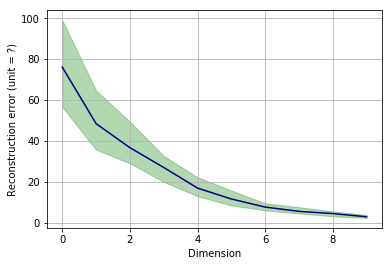

In [19]:
numDimsToPlot = 10

ERROR = np.zeros((numCases,numDimsToPlot))

for d in range(0,numDimsToPlot):
    for k in range(0,numCases):
        
        ### TODO: project the k-th sample as: P^T x (sample - average)
        ### beware of dimensions / transpositions !
        ### you can use "@" or "np.matmul" for matrix multiplication        
        xi = ### YOUR CODE HERE ###
        yi = ### YOUR CODE HERE ###
        
        ### TODO: set dimensions after the d-th to zero
        ### YOUR CODE HERE ###
        
        ### TODO: reconstruct the samples as: P x yi + average
        xi = ### YOUR CODE HERE ###
        
        ### TODO: compute the error between this reconstruction and the initial k-th sample
        ERROR[k,d] = ### YOUR CODE HERE ###
        
tsplot(range(0,numDimsToPlot), ERROR, n=1, percentile_min=25, percentile_max=75, plot_median=True, plot_mean=False, color='g', line_color='navy', alpha=0.3)

plt.xlabel('Dimension')
plt.ylabel('Reconstruction error (unit = ?)')


### Q1.6

Check your results with the **scikit-learn implementation of PCA** (for example the amount of explained variance):

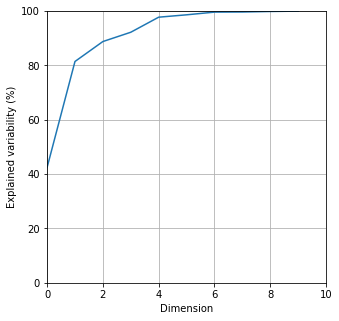

In [21]:
from sklearn.decomposition import PCA

numDimsToPlot = 10

### TODO: create a PCA model with numDimsToPlot components
### YOUR CODE HERE ###

### TODO: fit the model
### YOUR CODE HERE ###

### TODO: compute the explained variability as before
explainedVariability_SCIKIT = ### YOUR CODE HERE ###

fig,sub = plt.subplots(1,1,figsize=(5,5))
ax = sub
ax.plot( explainedVariability_SCIKIT )
ax.set_xlim(0,numDimsToPlot)
ax.set_ylim(0,100)
ax.grid()
plt.xlabel('Dimension')
plt.ylabel('Explained variability (%)')
plt.show()


## Part 2: Supervised dimensionality reduction with PLS

### Q2.1 
Use the **scikit-learn implementation of PLS regression** on the shape data:

In [22]:
from sklearn.cross_decomposition import PLSRegression

numDimsToPlot = 5

### TODO: create a PLS model with numDimsToPlot components
### YOUR CODE HERE ###

### TODO: fit the model
### YOUR CODE HERE ###


### Q2.2
**Reconstruct samples along the first dimensions** and visualize them:

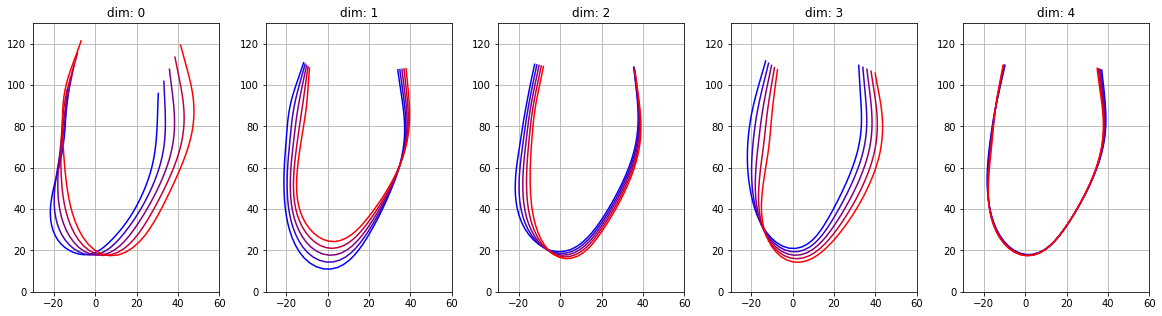

In [24]:
sigmaList = [-2,-1,0,1,2]

fig,sub = plt.subplots(1,numDimsToPlot,figsize=(20,10))

plt.subplots_adjust(wspace=0.25, hspace=0.1)
for d in range(0,numDimsToPlot):
    for si, s in enumerate(sigmaList):
        ax = sub[d]

        xiS = np.zeros(numDimsToPlot)
        tmpS = np.var(pls.x_scores_,axis=0)        
        xiS[d] = s * tmpS[d]
                
        ### TODO: complement the reconstruction formula
        xi = ### YOUR CODE HERE ###
        
        tmpX = np.reshape(xi,(2,numCP)).T
        
        alphaT = si / (len(sigmaList)-1)
        colorT = (alphaT,0,1-alphaT)
        
        ax.plot(tmpX[:,0],tmpX[:,1],color=colorT,alpha=1)
        ax.set_aspect('equal')
        ax.set_xlim(-30,60)
        ax.set_ylim(0,130)
        ax.grid()
        ax.set_title('dim: ' + str(d))

plt.show()

### Q2.3
How does this **compare to your previous results using PCA?**

>TODO: Your answer here.

## Part 3: To go further

### Q3.1 
Try the PCA and/or PLS models on other configurations:
- on the end-systolic shapes
- only for the healthy or diseased subgroups (is PLS possible in this case?)
- PCA on all 101 cases: are results comparable?

### Q3.2
Use the PCA or PLS low-dimensional coordinates as input features to a clustering or classification algorithm, and compute the performance measures seen in TP1: what do you think?
